In [1]:
import warnings
from pathlib import Path

import numpy as np
import pytorch_lightning as pl
import torch
from matplotlib import pyplot as plt
from pytorch_lightning import loggers as pl_loggers

from zprp.models.gatys.data import GatysDataModule
from zprp.models.gatys.extractor import VGG11FeatureMapExtractor, VGG19FeatureMapExtractor
from zprp.models.gatys.model import GatysNST

In [2]:
LOG_PATH = "lightning_logs"
LOG_NAME = "gatys_basic"
DATA_PATH = Path("../data/gatys")

In [3]:
torch.set_float32_matmul_precision("high")
# lightning complaining about using only one worker in DataLoader
warnings.filterwarnings("ignore", ".*does not have many workers.*")

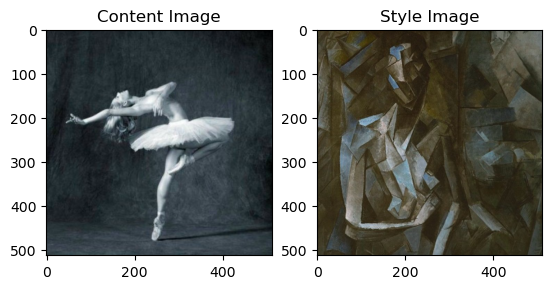

In [4]:
img_size = 512

dm = GatysDataModule(
    content_path=DATA_PATH / "content/dancing.jpg", style_path=DATA_PATH / "style/picasso.jpg", img_size=img_size
)
dm.setup("fit")

content_img, style_img = dm.train[0]
fix, axes = plt.subplots(1, 2)

axes[0].imshow(np.transpose(content_img, axes=(1, 2, 0)))
axes[0].set_title("Content Image")
axes[1].imshow(np.transpose(style_img, axes=(1, 2, 0)))
axes[1].set_title("Style Image")
plt.show()

In [ ]:
epochs = 100
tb_logger = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME)

In [12]:
def show_img(img: torch.Tensor, title: str = "") -> None:
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(img, axes=(1, 2, 0))[:, :, ::-1])
    plt.title(title)
    plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                     | Params
----------------------------------------------------------
0 | extractor    | VGG19FeatureMapExtractor | 20.0 M
1 | loss         | GatysNSTLoss             | 0     
  | other params | n/a                      | 786 K 
----------------------------------------------------------
786 K     Trainable params
20.0 M    Non-trainable params
20.8 M    Total params
83.243    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


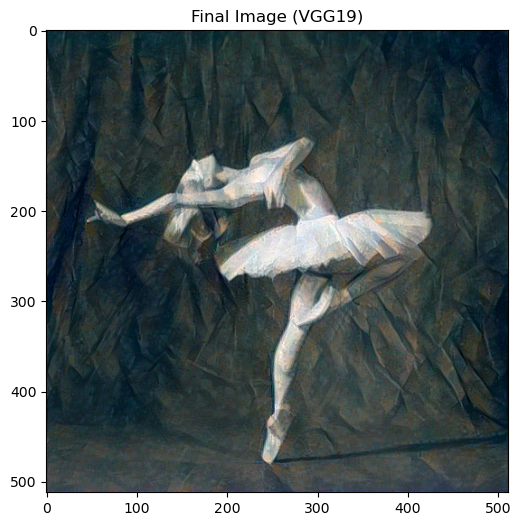

In [10]:
model = GatysNST(
    content_img=content_img,
    style_img=style_img,
    extractor=VGG19FeatureMapExtractor(),
    content_style_weights=(1e-5, 1e4),
    log_img_every_n_epochs=10
)


trainer = pl.Trainer(
    max_epochs=epochs, logger=tb_logger, enable_progress_bar=False, enable_checkpointing=False, log_every_n_steps=1
)
trainer.fit(model, dm)

show_img(model.image.cpu().numpy(), title="Final Image (VGG19)")

#### Using a smaller feature extractor

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                     | Params
----------------------------------------------------------
0 | extractor    | VGG11FeatureMapExtractor | 9.2 M 
1 | loss         | GatysNSTLoss             | 0     
  | other params | n/a                      | 786 K 
----------------------------------------------------------
786 K     Trainable params
9.2 M     Non-trainable params
10.0 M    Total params
40.028    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


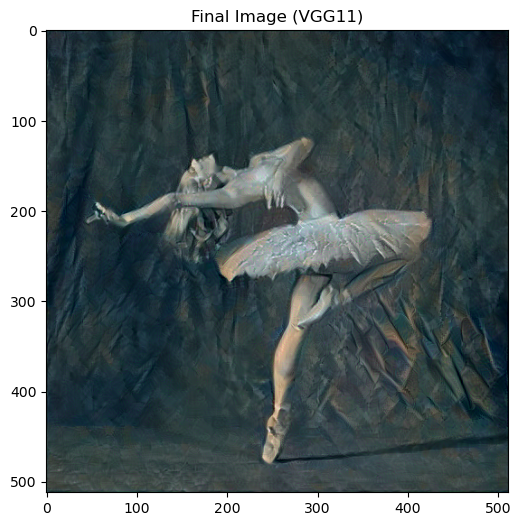

In [13]:
model = GatysNST(
    content_img=content_img,
    style_img=style_img,
    extractor=VGG11FeatureMapExtractor(),
    content_style_weights=(1e-5, 1e4),
    log_img_every_n_epochs=10
)


trainer = pl.Trainer(
    max_epochs=epochs, logger=tb_logger, enable_progress_bar=False, enable_checkpointing=False, log_every_n_steps=1
)
trainer.fit(model, dm)

show_img(model.image.cpu().numpy(), title="Final Image (VGG11)")

## conclusions
- smaller net - general look matches, but details are less refined (eg. look at the dancer's tutu - much less boxy when using VGG11)
- smaller net - bigger loss on same amount of epochs wow
- other architectures than vgg (resnet, mobilnet etc) requires adjusting style transfer model building function 